In [76]:
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as web
import datetime as dt 

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [77]:
crypto_currency = 'BNB'
against_currency ='USD'

In [78]:
start = dt.datetime(2021,1,1)
end = dt.datetime.now()-dt.timedelta(days=50)

In [79]:
data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo',start, end)

In [80]:
def difference(data, interval=1):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]
def invert_difference(orig_data, diff_data, interval=1):
	return [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]
from scipy.stats import boxcox

In [172]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)
prediction_days = 5
future_days=0
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_days):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))

In [173]:
# range(prediction_days, len(scaled_data))x_train
x_train.shape

(122, 5, 1)

In [181]:
#creating neural netowrk
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(LSTM(units=100))
# model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, epochs=500, batch_size=10)

ch 260/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 261/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0020
Epoch 262/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0020
Epoch 263/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0019
Epoch 264/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0018
Epoch 265/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 266/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 267/500
13/13 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 268/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 269/500
13/13 [==============================] - 0s 16ms/step - loss: 0.0025
Epoch 270/500
13/13 [==============================] - 0s 14ms/step - loss: 0.0020
Epoch 271/500
13/13 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 2

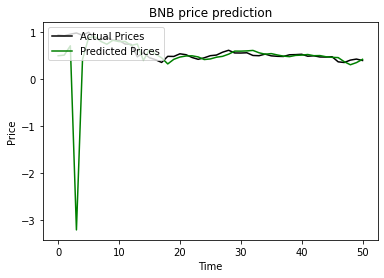

In [182]:
test_start = dt.datetime.now()-dt.timedelta(days=50)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo', test_start, test_end)
test_data['Close'] = scaler.transform(test_data['Close'].values.reshape(-1,1))
actual_prices = (test_data['Close'].values)#difference(np.log10((test_data['Close']))).to_numpy()

total_dataset = pd.concat((data['Close'],test_data['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:]
# model_inputs=difference(np.log10((model_inputs))).to_numpy()
# model_inputs = model_inputs
# model_inputs = scaler.fit_transform(model_inputs)


x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

prediction_prices = model.predict(x_test)
# prediction_prices = scaler.inverse_transform(prediction_prices) 
plt.plot(actual_prices,color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [180]:
# # Predict Next Day
# real_data = [model_inputs[len(model_inputs) +1 - prediction_days: len(model_inputs) + 1,0]]
# real_data = np.reshape(real_data,-1)
# real_data = np.reshape(real_data, (real_data.shape))
# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print()
(prediction_prices)

array([[1.2217462 ],
       [1.2601551 ],
       [1.3616174 ],
       [0.5195854 ],
       [1.3721251 ],
       [0.9195869 ],
       [0.9515039 ],
       [0.8791348 ],
       [0.8403897 ],
       [0.86419773],
       [0.8310225 ],
       [0.8184855 ],
       [0.7586528 ],
       [0.7394279 ],
       [0.5215416 ],
       [0.53011143],
       [0.46257877],
       [0.4084584 ],
       [0.34296668],
       [0.45532748],
       [0.48283285],
       [0.5258921 ],
       [0.517403  ],
       [0.46429616],
       [0.413677  ],
       [0.43686715],
       [0.4870796 ],
       [0.50686836],
       [0.5564312 ],
       [0.60145104],
       [0.5649773 ],
       [0.5492966 ],
       [0.55361986],
       [0.50907826],
       [0.49041593],
       [0.51960933],
       [0.49802825],
       [0.47977522],
       [0.4740752 ],
       [0.50632095],
       [0.51670295],
       [0.5228784 ],
       [0.4883119 ],
       [0.4864282 ],
       [0.4678612 ],
       [0.462096  ],
       [0.46741626],
       [0.375

In [122]:
re = data['Close']).reshape(-1,1)
data2 = scaler.fit_transform(re)
# data2[3:]
plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')

<ipython-input-122-be717895716d>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')


AttributeError: 'list' object has no attribute 'to_numpy'

In [ ]:
pd.Series(np.array(boxcox(data['Close'])))

AttributeError: 'tuple' object has no attribute 'transpose'